Code from the template

In [2]:
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

import matplotlib.pyplot as plt

class CircleDataGenerator():
    def one_class_generate(self, radius, y, n):
        angle = np.random.uniform(0, 2 * np.pi, n)
        noise = np.random.uniform(-1, 1, n)
        r = radius + noise
        x1 = np.cos(angle) * r
        x2 = np.sin(angle) * r
        x = np.stack([x1, x2], axis=1)
        t = np.ones((n,), dtype=np.int64) * int(y)
        return x, t

    
    def generate_sample(self, n):
        x1, t1 = self.one_class_generate(4, 1, n//2)
        x0, t0 = self.one_class_generate(1, 0, n//2)
        
        x = np.concatenate((x1, x0), axis=0)
        t = np.concatenate((t1, t0), axis=0)

        x = torch.tensor(x, dtype=torch.float32)
        t = torch.tensor(t, dtype=torch.long)

        return x, t


def plot_decision_boundary(gt_data, gt_target, model):
    step_size = 0.1
    xmin = -5
    xmax = 5
    ymin = -5
    ymax = 5
    xx, yy = torch.meshgrid(torch.arange(xmin, xmax+step_size, step_size), 
                            torch.arange(ymin, ymax+step_size, step_size))
    grid_data = torch.stack([xx.flatten(), yy.flatten()], dim=1)

    model.eval()
    y = model.forward(grid_data.to('cuda'))
    y = torch.softmax(y, dim=1)
    y = y.detach().cpu().numpy()

    prob = y[:, 0].reshape(xx.shape)

    data = gt_data.detach().cpu().numpy()
    t = gt_target.detach().cpu().numpy()

    plt.imshow(prob.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='RdBu')
    plt.contour(xx, yy, prob, [0.5], origin='lower', colors='k')
    plt.plot(data[t == 0, 0], data[t == 0, 1], 'o', color='orange')
    plt.plot(data[t == 1, 0], data[t == 1, 1], 'o', color='lightgreen')
    

class MNISTData():
    def __init__(self, batch_size):
        # transforms
        transform = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Normalize((0.1307,), (0.3081,))])
                                        # transforms.Lambda(torch.flatten)])        
        transform = transforms.ToTensor()
        self.train_set = torchvision.datasets.MNIST('./data', download=True, train=True, transform=transform)
        self.test_set = torchvision.datasets.MNIST('./data', download=True, train=False, transform=transform)

        # split train_set into train_subset and val_subset
        self.train_subset = Subset(self.train_set, list(range(5000)))
        self.val_subset = Subset(self.train_set, list(range(5000, 15000)))

        # dataloaders
        self.train_loader = torch.utils.data.DataLoader(self.train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
        self.val_loader = torch.utils.data.DataLoader(self.val_subset, batch_size=batch_size, shuffle=True, num_workers=0)
        self.test_loader = torch.utils.data.DataLoader(self.test_set, batch_size=batch_size, shuffle=False, num_workers=0)

# Part 1: Initialization - Shallow Network

In [3]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [39]:
n = 100
batch_size = n

cdg = CircleDataGenerator()
train_data = cdg.generate_sample(n)
train_loader = torch.utils.data.DataLoader(list(zip(train_data[0], train_data[1])), batch_size=batch_size, shuffle=True, num_workers=0)
val_data = cdg.generate_sample(n)
val_loader = torch.utils.data.DataLoader(list(zip(val_data[0], val_data[1])), batch_size=batch_size, shuffle=True, num_workers=0)

In [5]:
a = list(zip(train_data[0], train_data[1]))

Network and training loop

In [123]:
from torch import nn

class Shallow(nn.Module):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma
        self.net = nn.Sequential(
            nn.Linear(2, 6),
            nn.ReLU(),
            nn.Linear(6, 3),
            nn.ReLU(),
            nn.Linear(3, 2),
            nn.LogSoftmax(dim=1)
        )
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight.data, 0, self.sigma)
            nn.init.zeros_(m.bias.data)
            
    def forward(self, x):
        return self.net(x)
    
def accuracy(y, target):
    return (torch.argmax(y, 1) == target).float().mean().item()
    
def evaluate(net, loss_fun, loader):
    net.eval()
    loss = 0
    acc = 0

    for x, target in loader:
        x, target = x.to(dev), target.to(dev)
        y = net.forward(x)
        loss += loss_fun(y, target).mean().item()
        acc += accuracy(y, target)

    return loss / len(loader), acc / len(loader)

In [124]:
def train(net, train_loader, val_loader, lr=1e-1, epochs=1, verbose=True):
    loss_fun = nn.NLLLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = 0
        train_acc = 0

        for x, target in train_loader:
            x = x.to(dev)
            target = target.to(dev)
            y = net.forward(x)
            l = loss_fun(y, target)
            
            optimizer.zero_grad()
            l.mean().backward()
            optimizer.step()
            
            
            with torch.no_grad():
                train_loss += l.mean().item()
                train_acc += accuracy(y, target)

        if verbose:
            with torch.no_grad():
                net.eval()
                train_loss /= len(train_loader)
                train_acc /= len(train_loader)
            
            val_loss, val_acc = evaluate(net, loss_fun, val_loader)
            print(f"{epoch}: Training / validation acc/loss: {train_acc:.3f}/{train_loss:.3f} / {val_acc:.3f}/{val_loss:.3f}")
        
# train(Shallow(1).to(dev), train_loader, epochs=10)

Playing with different sigma (initialization)

In [ ]:
def plot_decision_boundary(gt_data, gt_target, model):
    step_size = 0.1
    xmin = -5
    xmax = 5
    ymin = -5
    ymax = 5
    xx, yy = torch.meshgrid(torch.arange(xmin, xmax+step_size, step_size), 
                            torch.arange(ymin, ymax+step_size, step_size))
    grid_data = torch.stack([xx.flatten(), yy.flatten()], dim=1)

    model.eval()
    y = model.forward(grid_data.to('cuda'))
    y = torch.softmax(y, dim=1)
    y = y.detach().cpu().numpy()

    prob = y[:, 0].reshape(xx.shape)

    data = gt_data.detach().cpu().numpy()
    t = gt_target.detach().cpu().numpy()

    plt.imshow(prob.T, origin='lower', extent=(xmin, xmax, ymin, ymax), cmap='RdBu')
    plt.contour(xx, yy, prob, [0.5], origin='lower', colors='k')
    plt.plot(data[t == 0, 0], data[t == 0, 1], 'o', color='orange')
    plt.plot(data[t == 1, 0], data[t == 1, 1], 'o', color='lightgreen')

Good initialization

In [59]:
epochs = 1000

sigma = 2 / (3 + 6)
net1 = Shallow(sigma).to(dev)
train(net1, train_loader, val_loader, epochs=epochs)

0: Training / validation acc/loss: 0.500/0.684 / 0.540/0.685
1: Training / validation acc/loss: 0.540/0.683 / 0.570/0.685
2: Training / validation acc/loss: 0.600/0.683 / 0.620/0.684
3: Training / validation acc/loss: 0.650/0.682 / 0.650/0.684
4: Training / validation acc/loss: 0.670/0.681 / 0.690/0.683
5: Training / validation acc/loss: 0.670/0.680 / 0.680/0.682
6: Training / validation acc/loss: 0.700/0.680 / 0.690/0.682
7: Training / validation acc/loss: 0.700/0.679 / 0.690/0.681
8: Training / validation acc/loss: 0.710/0.678 / 0.650/0.680
9: Training / validation acc/loss: 0.710/0.677 / 0.650/0.679
10: Training / validation acc/loss: 0.700/0.676 / 0.650/0.678
11: Training / validation acc/loss: 0.720/0.675 / 0.670/0.678
12: Training / validation acc/loss: 0.720/0.674 / 0.670/0.676
13: Training / validation acc/loss: 0.730/0.672 / 0.680/0.675
14: Training / validation acc/loss: 0.730/0.671 / 0.700/0.674
15: Training / validation acc/loss: 0.730/0.670 / 0.700/0.673
16: Training / val

/usr/local/lib/python3.9/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


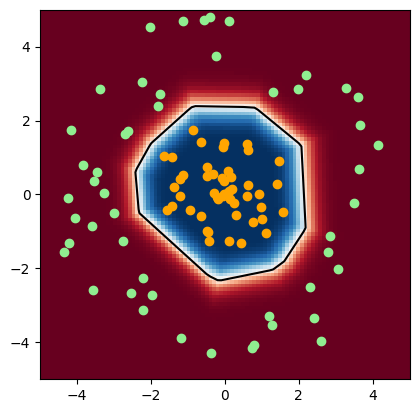

In [49]:
plot_decision_boundary(train_data[0], train_data[1], net1)

As we can see, the accuracy is perfect and the decision boundary is also near perfect. The sequence converge near the epoch 149

Small sigma

In [60]:
sigma = 0.05
net2 = Shallow(sigma).to(dev)
train(net2, train_loader, val_loader, epochs=epochs)

0: Training / validation acc/loss: 0.460/0.693 / 0.460/0.693
1: Training / validation acc/loss: 0.400/0.693 / 0.400/0.693
2: Training / validation acc/loss: 0.380/0.693 / 0.340/0.693
3: Training / validation acc/loss: 0.360/0.693 / 0.350/0.693
4: Training / validation acc/loss: 0.330/0.693 / 0.350/0.693
5: Training / validation acc/loss: 0.300/0.693 / 0.330/0.693
6: Training / validation acc/loss: 0.290/0.693 / 0.350/0.693
7: Training / validation acc/loss: 0.300/0.693 / 0.370/0.693
8: Training / validation acc/loss: 0.320/0.693 / 0.410/0.693
9: Training / validation acc/loss: 0.370/0.693 / 0.410/0.693
10: Training / validation acc/loss: 0.400/0.693 / 0.420/0.693
11: Training / validation acc/loss: 0.400/0.693 / 0.420/0.693
12: Training / validation acc/loss: 0.410/0.693 / 0.420/0.693
13: Training / validation acc/loss: 0.420/0.693 / 0.430/0.693
14: Training / validation acc/loss: 0.420/0.693 / 0.430/0.693
15: Training / validation acc/loss: 0.430/0.693 / 0.430/0.693
16: Training / val

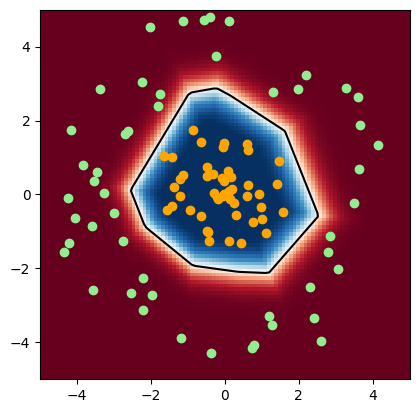

In [61]:
plot_decision_boundary(train_data[0], train_data[1], net2)

Weights converge, but much later, after ~500 epochs

Big sigma

In [73]:
sigma = 20
net3 = Shallow(sigma).to(dev)
train(net3, train_loader, val_loader, epochs=epochs)

0: Training / validation acc/loss: 0.510/12001.704 / 0.500/12718.478
1: Training / validation acc/loss: 0.500/8478.695 / 0.500/79.916
2: Training / validation acc/loss: 0.500/54.040 / 0.510/0.686
3: Training / validation acc/loss: 0.520/0.679 / 0.510/0.686
4: Training / validation acc/loss: 0.520/0.679 / 0.510/0.686
5: Training / validation acc/loss: 0.520/0.679 / 0.510/0.686
6: Training / validation acc/loss: 0.520/0.679 / 0.510/0.686
7: Training / validation acc/loss: 0.520/0.679 / 0.510/0.686
8: Training / validation acc/loss: 0.520/0.679 / 0.510/0.686
9: Training / validation acc/loss: 0.520/0.679 / 0.510/0.686
10: Training / validation acc/loss: 0.520/0.679 / 0.510/0.686
11: Training / validation acc/loss: 0.520/0.679 / 0.510/0.686
12: Training / validation acc/loss: 0.520/0.679 / 0.510/0.686
13: Training / validation acc/loss: 0.520/0.679 / 0.510/0.686
14: Training / validation acc/loss: 0.520/0.679 / 0.510/0.686
15: Training / validation acc/loss: 0.520/0.679 / 0.510/0.686
16: T

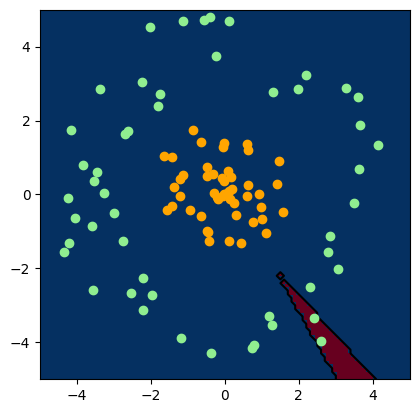

In [74]:
plot_decision_boundary(train_data[0], train_data[1], net3)

Sigma is too big, the sequence diverge

Glorot initiazliation

In [78]:
class Glorot(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 6),
            nn.ReLU(),
            nn.Linear(6, 3),
            nn.ReLU(),
            nn.Linear(3, 2),
            nn.LogSoftmax(dim=1)
        )
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight.data)
            nn.init.zeros_(m.bias.data)
            
    def forward(self, x):
        return self.net(x)
    
glorot = Glorot()
train(glorot.to(dev), train_loader, val_loader, epochs=epochs)

0: Training / validation acc/loss: 0.500/0.558 / 0.510/0.590
1: Training / validation acc/loss: 0.540/0.541 / 0.550/0.574
2: Training / validation acc/loss: 0.570/0.528 / 0.590/0.560
3: Training / validation acc/loss: 0.620/0.516 / 0.600/0.548
4: Training / validation acc/loss: 0.650/0.505 / 0.610/0.537
5: Training / validation acc/loss: 0.690/0.496 / 0.630/0.527
6: Training / validation acc/loss: 0.700/0.487 / 0.640/0.518
7: Training / validation acc/loss: 0.710/0.478 / 0.670/0.510
8: Training / validation acc/loss: 0.720/0.470 / 0.700/0.502
9: Training / validation acc/loss: 0.730/0.463 / 0.730/0.494
10: Training / validation acc/loss: 0.730/0.455 / 0.740/0.487
11: Training / validation acc/loss: 0.730/0.448 / 0.750/0.480
12: Training / validation acc/loss: 0.750/0.441 / 0.750/0.474
13: Training / validation acc/loss: 0.760/0.435 / 0.750/0.467
14: Training / validation acc/loss: 0.790/0.428 / 0.770/0.460
15: Training / validation acc/loss: 0.830/0.421 / 0.770/0.454
16: Training / val

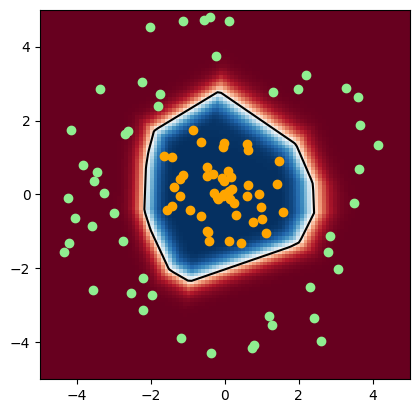

In [79]:
plot_decision_boundary(train_data[0], train_data[1], glorot)

With glorot initialization the sequence converge much faster (near the epoch 60)!

Data scaling

In [130]:
from copy import deepcopy

def scale(data, factor):
    new_data = deepcopy(data)
    for i in range(len(data[0])):
        new_data[0][i] *= factor
    return new_data

def scale_and_train(factor):
    scaled_train_data = scale(train_data, factor)
    train_loader = torch.utils.data.DataLoader(list(zip(scaled_train_data[0], scaled_train_data[1])), batch_size=batch_size, shuffle=True, num_workers=0)
    scaled_val_data = scale(val_data, factor)
    val_loader = torch.utils.data.DataLoader(list(zip(scaled_val_data[0], scaled_val_data[1])), batch_size=batch_size, shuffle=True, num_workers=0)
    
    net = Glorot().to(dev)
    train(net, train_loader, val_loader, epochs=epochs, verbose=True);
    
    # plot_decision_boundary(scaled_train_data[0], scaled_train_data[1], net)

In [131]:
scale_and_train(0.1)

0: Training / validation acc/loss: 0.550/0.712 / 0.500/0.711
1: Training / validation acc/loss: 0.520/0.711 / 0.480/0.710
2: Training / validation acc/loss: 0.510/0.710 / 0.470/0.710
3: Training / validation acc/loss: 0.480/0.710 / 0.460/0.709
4: Training / validation acc/loss: 0.470/0.709 / 0.430/0.709
5: Training / validation acc/loss: 0.420/0.709 / 0.440/0.708
6: Training / validation acc/loss: 0.420/0.708 / 0.410/0.707
7: Training / validation acc/loss: 0.370/0.707 / 0.390/0.706
8: Training / validation acc/loss: 0.330/0.705 / 0.350/0.704
9: Training / validation acc/loss: 0.310/0.703 / 0.330/0.701
10: Training / validation acc/loss: 0.290/0.700 / 0.330/0.699
11: Training / validation acc/loss: 0.300/0.697 / 0.360/0.696
12: Training / validation acc/loss: 0.340/0.694 / 0.380/0.693
13: Training / validation acc/loss: 0.390/0.691 / 0.410/0.691
14: Training / validation acc/loss: 0.420/0.690 / 0.410/0.689
15: Training / validation acc/loss: 0.420/0.688 / 0.430/0.689
16: Training / val

By scaling the data by factor of 0.1 we've moved the convergence moment by about 700 epochs 

In [134]:
scale_and_train(50)

0: Training / validation acc/loss: 0.500/25.619 / 0.500/152.772
1: Training / validation acc/loss: 0.500/160.012 / 0.500/4.484
2: Training / validation acc/loss: 0.500/4.760 / 0.500/0.693
3: Training / validation acc/loss: 0.500/0.693 / 0.500/0.693
4: Training / validation acc/loss: 0.500/0.693 / 0.500/0.693
5: Training / validation acc/loss: 0.500/0.693 / 0.500/0.693
6: Training / validation acc/loss: 0.500/0.693 / 0.500/0.693
7: Training / validation acc/loss: 0.500/0.693 / 0.500/0.693
8: Training / validation acc/loss: 0.500/0.693 / 0.500/0.693
9: Training / validation acc/loss: 0.500/0.693 / 0.500/0.693
10: Training / validation acc/loss: 0.500/0.693 / 0.500/0.693
11: Training / validation acc/loss: 0.500/0.693 / 0.500/0.693
12: Training / validation acc/loss: 0.500/0.693 / 0.500/0.693
13: Training / validation acc/loss: 0.500/0.693 / 0.500/0.693
14: Training / validation acc/loss: 0.500/0.693 / 0.500/0.693
15: Training / validation acc/loss: 0.500/0.693 / 0.500/0.693
16: Training 

Using the scaling by factor of 50 the sequence diverge

# Part 2: Initialization - Deep Network

Initialize using N(0, 1)

In [116]:
class Deep(nn.Module):
    def __init__(self, sigma, neurons=100):
        super().__init__()
        self.sigma = sigma
        self.mean = np.zeros(20)
        self.std = np.zeros(20)
        
        first = nn.Sequential(
            nn.Linear(2, neurons),
            nn.ReLU(),
        )
        
        layers = []
        for _ in range(18):
            layers.append(
                nn.Sequential(
                    nn.Linear(neurons, neurons),
                    nn.ReLU(),
                )
            )
        
        last = nn.Sequential(
            nn.Linear(neurons, 2),
            nn.LogSoftmax(dim=1)
        )
        self.net = nn.Sequential(*[first, *layers, last])
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight.data, 0, self.sigma)
            nn.init.zeros_(m.bias.data)
            
    def forward(self, x):
        for i in range(20):
            x = self.net[i](x)
            a = x.detach().cpu().numpy()
            self.mean[i] = np.average(a)
            self.std[i] = np.std(a)
        return x

n = 1000
new_data = cdg.generate_sample(n)
loader = torch.utils.data.DataLoader(list(zip(new_data[0], new_data[1])), batch_size=n, shuffle=True, num_workers=0)
net = Deep(1).to(dev)

for x, t in loader:
    x, t = x.to(dev), t.to(dev)
    net(x)
    
print(net.mean)
print(net.std)

[ 1.02340043e+00  6.30205822e+00  5.45692291e+01  3.58305908e+02
  2.46778149e+03  1.33914229e+04  8.39902109e+04  6.80035938e+05
  4.39589450e+06  3.07863300e+07  2.60776800e+08  1.74525606e+09
  1.46150021e+10  8.31007130e+10  6.35754775e+11  4.81339900e+12
  2.73760167e+13  2.14284190e+14  1.35745797e+15 -7.93854804e+15]
[1.93721962e+00 1.35830669e+01 1.01165390e+02 7.13236633e+02
 4.76375732e+03 2.82326484e+04 1.87848219e+05 1.27132925e+06
 9.01308100e+06 6.61449520e+07 4.42607488e+08 3.30139392e+09
 2.41341256e+10 1.60421036e+11 1.18547205e+12 7.95759503e+12
 5.48872032e+13 4.00462851e+14 2.66500788e+15 1.40564358e+16]


From the output above we can conclude that with given initialization mean activations are rapidly exploding and reaching std ~10^16 at the end

In [118]:
class DeepGlorot(nn.Module):
    def __init__(self, neurons=100):
        super().__init__()
        self.mean = np.zeros(20)
        self.std = np.zeros(20)
        
        first = nn.Sequential(
            nn.Linear(2, neurons),
            nn.ReLU(),
        )
        
        layers = []
        for _ in range(18):
            layers.append(
                nn.Sequential(
                    nn.Linear(neurons, neurons),
                    nn.ReLU(),
                )
            )
        
        last = nn.Sequential(
            nn.Linear(neurons, 2),
            nn.LogSoftmax(dim=1)
        )
        self.net = nn.Sequential(*[first, *layers, last])
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight.data)
            nn.init.zeros_(m.bias.data)
            
    def forward(self, x):
        for i in range(20):
            x = self.net[i](x)
            a = x.detach().cpu().numpy()
            self.mean[i] = np.average(a)
            self.std[i] = np.std(a)
        return x

deep_glorot = DeepGlorot().to(dev)

for x, t in loader:
    x, t = x.to(dev), t.to(dev)
    deep_glorot(x)
    
print(deep_glorot.mean)
print(deep_glorot.std)


[ 1.51147604e-01  9.49673206e-02  6.57034367e-02  5.24935238e-02
  4.24583107e-02  3.51425372e-02  2.46521384e-02  1.86332744e-02
  1.14116305e-02  8.99655558e-03  6.45197462e-03  4.10100725e-03
  2.64904276e-03  1.47272018e-03  1.33905397e-03  9.49021662e-04
  8.46975308e-04  6.12025498e-04  4.78663191e-04 -6.93147242e-01]
[2.60561556e-01 1.73813149e-01 1.22584157e-01 9.28085372e-02
 8.06289464e-02 6.08070754e-02 4.56339195e-02 3.60786952e-02
 2.50860974e-02 1.65917575e-02 1.15203243e-02 7.46552460e-03
 5.10137854e-03 3.44709447e-03 2.77481577e-03 1.89852621e-03
 1.47712731e-03 1.24885899e-03 8.91709409e-04 1.83684766e-04]


As we can see the Glorot initialization successfully solves this problem. The mean is normal. The std is still a bit big, but I can't call this "explosion"

# Part 3: Regularization - Dropout

In [136]:
batch_size = 32
mnist = MNISTData(batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [146]:
def train_with_adam(net, train_loader, val_loader, lr=3e-4, epochs=1, verbose=True):
    loss_fun = nn.NLLLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr)
    
    for epoch in range(epochs):
        net.train()
        
        train_loss = 0
        train_acc = 0

        for x, target in train_loader:
            x = x.to(dev)
            target = target.to(dev)
            y = net.forward(x)
            l = loss_fun(y, target)
            
            optimizer.zero_grad()
            l.mean().backward()
            optimizer.step()
            
            
            with torch.no_grad():
                train_loss += l.mean().item()
                train_acc += accuracy(y, target)

        if verbose:
            with torch.no_grad():
                net.eval()
                train_loss /= len(train_loader)
                train_acc /= len(train_loader)
            
            val_loss, val_acc = evaluate(net, loss_fun, val_loader)
            print(f"{epoch}: Training / validation acc/loss: {train_acc:.3f}/{train_loss:.3f} / {val_acc:.3f}/{val_loss:.3f}")

In [147]:
class MNISTNet(nn.Module):
    def __init__(self, sigma, dropout=0.0):
        super().__init__()
        self.sigma = sigma
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            
            nn.Linear(784, 800),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(800, 10),
            nn.LogSoftmax(dim=1)
        )
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight.data, 0, self.sigma)
            nn.init.zeros_(m.bias.data)
            
    def forward(self, x):
        return self.net(x)

In [151]:
net1 = MNISTNet(0.1, dropout=0.0).to(dev)
train_with_adam(net1, mnist.train_loader, mnist.val_loader, epochs=10)

0: Training / validation acc/loss: 0.812/0.691 / 0.894/0.369
1: Training / validation acc/loss: 0.945/0.179 / 0.910/0.318
2: Training / validation acc/loss: 0.982/0.065 / 0.913/0.301
3: Training / validation acc/loss: 0.995/0.030 / 0.922/0.275
4: Training / validation acc/loss: 0.999/0.014 / 0.920/0.298
5: Training / validation acc/loss: 1.000/0.009 / 0.926/0.270
6: Training / validation acc/loss: 1.000/0.005 / 0.928/0.272
7: Training / validation acc/loss: 1.000/0.004 / 0.929/0.271
8: Training / validation acc/loss: 1.000/0.003 / 0.929/0.276
9: Training / validation acc/loss: 1.000/0.003 / 0.931/0.273


In [155]:
net2 = MNISTNet(0.1, dropout=0.5).to(dev)
train_with_adam(net2, mnist.train_loader, mnist.val_loader, epochs=50)

0: Training / validation acc/loss: 0.261/8.312 / 0.761/0.773
1: Training / validation acc/loss: 0.439/3.938 / 0.806/0.608
2: Training / validation acc/loss: 0.530/2.771 / 0.832/0.513
3: Training / validation acc/loss: 0.588/2.175 / 0.848/0.472
4: Training / validation acc/loss: 0.623/1.831 / 0.852/0.456
5: Training / validation acc/loss: 0.639/1.583 / 0.863/0.438
6: Training / validation acc/loss: 0.649/1.447 / 0.873/0.422
7: Training / validation acc/loss: 0.676/1.273 / 0.881/0.405
8: Training / validation acc/loss: 0.694/1.197 / 0.882/0.404
9: Training / validation acc/loss: 0.702/1.123 / 0.883/0.405
10: Training / validation acc/loss: 0.715/1.057 / 0.893/0.391
11: Training / validation acc/loss: 0.711/1.017 / 0.895/0.393
12: Training / validation acc/loss: 0.732/0.912 / 0.895/0.393
13: Training / validation acc/loss: 0.749/0.846 / 0.894/0.384
14: Training / validation acc/loss: 0.755/0.829 / 0.899/0.383
15: Training / validation acc/loss: 0.762/0.801 / 0.901/0.376
16: Training / val

So yep dropout had strong regularization effect. We had to train the network 5 times longer, but this is good prevention from overfitting as we can see on the training accuracy/loss